# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
import zipfile
import pandas as pd
import os

with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


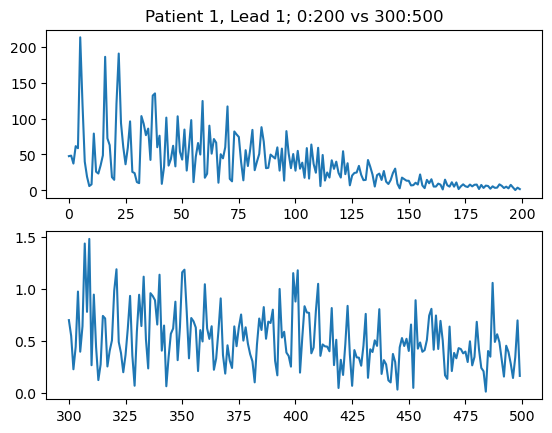

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)
ax[1].plot(range(300,500), data.iloc[0,300:500])
ax[0].set_title("Patient 1, Lead 1; 0:200 vs 300:500")
ax[0].plot(range(0,200), data.iloc[0,:200])
plt.show()

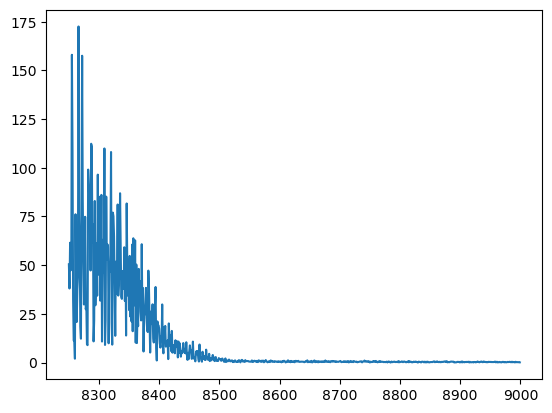

In [4]:
fig, ax = plt.subplots(1,1)
ax.plot(range(8250,9000), data.iloc[0,8250:9000])
plt.show()

In [5]:
labels = data.iloc[:,-1]
print(labels.value_counts())
print(data.head())

0    681
1    146
Name: label, dtype: int64
          0_0         0_1         0_2        0_3        0_4         0_5  \
0   47.685046   48.416904   37.371002  61.604757  58.732738  213.067966   
1  152.726718  297.353726  111.168880  25.419423  14.636085   24.609688   
2    1.601260    3.882169   22.978997  21.673040   8.919484   18.329286   
3    1.388947    3.052483    3.084103   4.627886  10.016196   15.020347   
4    3.625561    3.728466    6.205367  17.722897   5.699401    9.024836   

          0_6         0_7         0_8         0_9  ...    11_741    11_742  \
0  120.890451   40.100639   19.106303    6.043738  ...  0.078753  0.379885   
1   49.533842  253.651571  483.852043  167.617409  ...  0.804160  0.809705   
2   27.710604   23.350084   37.896254    8.331180  ...  0.156080  0.102070   
3  139.823127   20.149108   10.393109    9.241921  ...  0.238274  0.096733   
4   15.782812   33.336480   55.257804   19.139128  ...  0.056914  0.059116   

     11_743    11_744    11_745    1

In [6]:
# Try to find the missing data
missing_values = data.isna().sum()
print(missing_values)



0_0       0
0_1       0
0_2       0
0_3       0
0_4       0
         ..
11_746    0
11_747    0
11_748    0
11_749    0
label     0
Length: 9001, dtype: int64
